In [22]:
import sys
sys.path.append("../")

import pandas as pd
import plotly.graph_objects as go

In [23]:
from Infrastructure.instrument_collection import instrumentCollection

In [24]:
def load_results(ic):
    res = []
    trades = []
    our_curr = ['USD', 'GBP', 'JPY', 'EUR']
    for p1 in our_curr:
        for p2 in our_curr:
            pair = f"{p1}_{p2}"
            if pair in ic.instruments_dict.keys():
                res.append(pd.read_pickle(f"./macd_ema/macd_ema_res_{pair}.pkl"))
                trades.append(pd.read_pickle(f"./macd_ema/trades/macd_ema_trades_{pair}.pkl"))
    return pd.concat(res), pd.concat(trades)

In [25]:
instrumentCollection.LoadInstruments('../data/')

In [26]:
df_results, df_trades = load_results(instrumentCollection)
df_results.reset_index(drop=True, inplace=True)
df_trades.reset_index(drop=True, inplace=True)

In [27]:
df_results.head()

,pair,slow,fast,ema,result,signal
0,USD_JPY,26,12,50,27.0,9
1,USD_JPY,26,12,100,14.5,9
2,USD_JPY,26,12,50,32.0,12
3,USD_JPY,26,12,100,23.5,12
4,USD_JPY,26,18,50,18.0,9


In [28]:
df_trades.head()

,running,start_index_m5,profit_factor,loss_factor,start_price,trigger_price,SIGNAL,TP,SL,result,end_time,start_time,slow,fast,signal,ema,pair
0,False,4065,1.5,-1.0,105.302,105.144,-1,105.1705,105.373,1.5,2020-10-21 07:10:00+00:00,2020-10-21 05:00:00+00:00,26,12,9,50,USD_JPY
1,False,5344,1.5,-1.0,104.424,104.032,-1,104.0485,104.656,1.5,2020-10-29 10:35:00+00:00,2020-10-27 17:00:00+00:00,26,12,9,50,USD_JPY
2,False,7068,1.5,-1.0,104.580,104.580,-1,104.7080,104.468,1.5,2020-11-04 18:00:00+00:00,2020-11-04 18:00:00+00:00,26,12,9,50,USD_JPY
3,False,10278,1.5,-1.0,103.799,103.853,-1,103.5160,103.821,-1.0,2020-11-19 22:00:00+00:00,2020-11-19 22:00:00+00:00,26,12,9,50,USD_JPY
4,False,13675,1.5,-1.0,103.993,104.049,-1,103.9035,104.031,-1.0,2020-12-07 18:20:00+00:00,2020-12-07 18:00:00+00:00,26,12,9,50,USD_JPY


In [29]:
df_results.columns

Index(['pair', 'slow', 'fast', 'ema', 'result', 'signal'], dtype='object')

In [30]:
# look at the results grouped by setting
gr = df_results.groupby(by=['slow', 'fast', 'ema', 'signal'], as_index=False).sum()

In [31]:
# sort descending, best result at the top
gr.sort_values(by='result', ascending=False, inplace=True)

In [32]:
gr.head()

,slow,fast,ema,signal,pair,result
15,52,18,100,12,USD_JPYGBP_USDGBP_JPYEUR_USDEUR_GBPEUR_JPY,62.5
0,26,12,50,9,USD_JPYGBP_USDGBP_JPYEUR_USDEUR_GBPEUR_JPY,61.5
1,26,12,50,12,USD_JPYGBP_USDGBP_JPYEUR_USDEUR_GBPEUR_JPY,60.0
5,26,18,50,12,USD_JPYGBP_USDGBP_JPYEUR_USDEUR_GBPEUR_JPY,59.5
13,52,18,50,12,USD_JPYGBP_USDGBP_JPYEUR_USDEUR_GBPEUR_JPY,58.5


In [54]:
# for the top setting, let's see what we have in terms of individual currency pairs
df_results_best = df_results[(df_results.ema==100)&(df_results.fast==18)&(df_results.slow==52)&(df_results.signal==12)]

In [55]:
df_results_best

,pair,slow,fast,ema,result,signal
15,USD_JPY,52,18,100,24.0,12
31,GBP_USD,52,18,100,20.0,12
47,GBP_JPY,52,18,100,12.5,12
63,EUR_USD,52,18,100,-11.0,12
79,EUR_GBP,52,18,100,12.5,12
95,EUR_JPY,52,18,100,4.5,12


In [56]:
# let's see the individual trades for the top setting
df_trades_best = df_trades[(df_trades.ema==50)&(df_trades.fast==18)&(df_trades.slow==52)&(df_trades.signal==9)].copy()

In [57]:
df_trades_best.columns

Index(['running', 'start_index_m5', 'profit_factor', 'loss_factor',
       'start_price', 'trigger_price', 'SIGNAL', 'TP', 'SL', 'result',
       'end_time', 'start_time', 'slow', 'fast', 'signal', 'ema', 'pair'],
      dtype='object')

In [58]:
# let's see how long trades last
df_trades_best['duration_h'] = (df_trades_best.end_time - df_trades_best.start_time).dt.total_seconds() / 3600

In [59]:
df_trades_best['duration_h'].describe()

count    451.000000
mean      18.062269
std       46.920727
min        0.000000
25%        0.083333
50%        2.250000
75%       14.625000
max      521.250000
Name: duration_h, dtype: float64

In [60]:
# win percentage
wp = (df_trades_best[df_trades_best.result>0].shape[0] / df_trades_best.shape[0]) * 100
print("Win percentage", wp)

Win percentage 43.23725055432372


In [61]:
# we will take a look at the cumulative gains, so sort by end_time
df_trades_best.sort_values(by='end_time', inplace=True)

In [51]:
df_trades_best['CUM_RES'] = df_trades_best.result.cumsum()

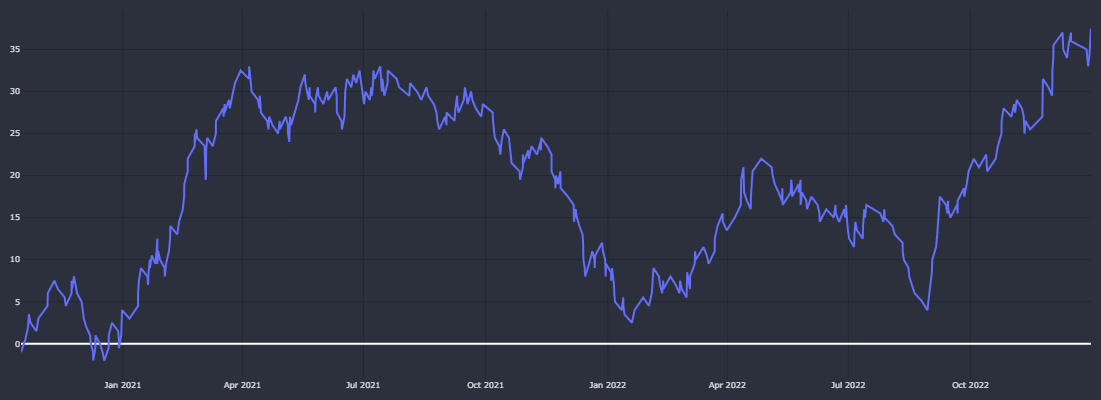

In [52]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=df_trades_best.end_time,
    y=df_trades_best['CUM_RES'],
    line=dict(width=2)
))

fig.update_yaxes(
    gridcolor="#1f292f"
)
fig.update_xaxes(
    gridcolor="#1f292f"
)

fig.update_layout(
    margin=dict(l=10,r=10,b=10,t=10),
    paper_bgcolor="#2c303c",
    plot_bgcolor="#2c303c",
    font=dict(size=8, color="#e1e1e1"),
    height=400
)

fig.show()